# eBPF Library Usage

This notebook investigates eBPF library usage using data pulled from [Sourcegraph](sourcegraph.com)

## Dataset

First let us scrape the necessary data from Sourcegraph

In [141]:
import getpass
SOURCEGRAPH_TOKEN = getpass.getpass("SOURCEGRAPH_API_TOKEN")

SOURCEGRAPH_API_TOKEN ········


In [175]:
import json
import urllib.parse
import requests

headers = {'Authorization': 'token {}'.format(SOURCEGRAPH_TOKEN)}

def repos_by_library(library, language, query):
    graphql = """
    query ($query: String!) {
      site {
        buildVersion
      }
      search(query: $query) {
        results {
          results {
            __typename
            ... on FileMatch {
              repository {
                name
                url
              }
            }
          }
          limitHit
          cloning {
            name
          }
          missing {
            name
          }
          timedout {
            name
          }
          resultCount
          elapsedMilliseconds
          ...SearchResultsAlertFields
        }
      }
    }

    fragment SearchResultsAlertFields on SearchResults {
      alert {
        title
        description
        proposedQueries {
          description
          query
        }
      }
    }
    """
    payload = { 'query': graphql, 'variables': { 'query': query } }
    r = requests.post('https://sourcegraph.com/.api/graphql', json=payload, headers=headers)
    results = json.loads(r.text)
    repos = {}
    for r in results["data"]["search"]["results"]["results"]:
        if r["repository"]["name"] not in repos:
            r = r["repository"]
            r["library"] = library
            r["language"] = language
            r["stars"] = get_stars(r["name"])
            repos[r["name"]] = r
    return repos

def get_stars(repo):
    graphql = """
    query GetStars($repoName: String!) {
      repository(name: $repoName) {
        stars
      }
    }
    """
    payload = { 'query': graphql, 'variables': { 'repoName': repo } }
    r = requests.post('https://sourcegraph.com/.api/graphql', json=payload, headers=headers)
    results = json.loads(r.text)
    return results["data"]["repository"]["stars"]

repos = {}

print("Getting libbpf stats")
libbpf_repos = repos_by_library('libbpf', 'C', '#include <bpf/libbpf.h> -repo:github.com/libbpf/libbpf lang:c fork:no -repohasfile:Kbuild count:4000')
repos.update(libbpf_repos)
print("Found {} repos".format(len(libbpf_repos)))

print("Getting cilium stats")
cilium_repos = repos_by_library('ebpf', 'Go', 'github.com/cilium/ebpf -repo:github.com/cilium/ebpf lang:go fork:no count:4000 -file:vendor')
repos.update(cilium_repos)
print("Found {} repos".format(len(cilium_repos)))

print("Getting libbpfgo stats")
libbpfgo_repos = repos_by_library('libbpfgo', 'Go', 'github.com/aquasecurity/libbpfgo -repo:github.com/aquasecurity/libbpfgo lang:go fork:no count:4000 -file:vendor')
repos.update(libbpfgo_repos)
print("Found {} repos".format(len(libbpfgo_repos)))

print("Getting aya stats")
aya_repos = repos_by_library('aya', 'Rust', 'file:Cargo.toml fork:no -repo:github.com/aya-rs (content:"aya =" OR content:"dependencies.aya")')
repos.update(aya_repos)
print("Found {} repos".format(len(aya_repos)))

print("Getting redbpf stats")
redbpf_repos = repos_by_library('redbpf', 'Rust', 'file:Cargo.toml fork:no -repo:github.com/foniod/redbpf (content:"redbpf =" OR content:"dependencies.redbpf")')
repos.update(redbpf_repos)
print("Found {} repos".format(len(redbpf_repos)))

print("Getting libbpf_rs stats")
libbpf_rs_repos = repos_by_library('libbpf-rs', 'Rust', 'file:Cargo.toml fork:no -repo:"libbpf" (content:"libbpf-rs =" OR content:"dependencies.libbpf-rs")')
repos.update(libbpf_rs_repos)
print("Found {} repos".format(len(libbpf_rs_repos)))

Getting libbpf stats
Found 152 repos
Getting cilium stats
Found 92 repos
Getting libbpfgo stats
Found 16 repos
Getting aya stats
Found 13 repos
Getting redbpf stats
Found 11 repos
Getting libbpf_rs stats
Found 9 repos


## Analysis

### eBPF Library Usage

This plot looks at the overall distribution of library usage across all projects.

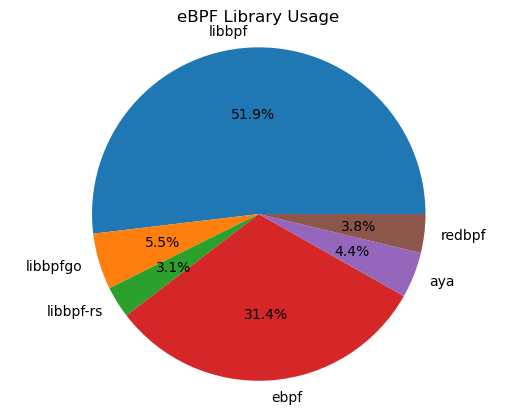

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline

sizes = [len(libbpf_repos), len(libbpfgo_repos), len(libbpf_rs_repos), len(cilium_repos), len(aya_repos), len(redbpf_repos)]
labels = 'libbpf', 'libbpfgo', 'libbpf-rs', 'ebpf', 'aya', 'redbpf'

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('eBPF Library Usage')
plt.axis('equal')

plt.show()

### eBPF Library Usage (Weighted by popularity)

This plot weights the distribution of libraries using "Github Stars".
This should give a more accurate impression of which libraries are popular since it will de-prioritize the many small sample/demo repositories in the dataset.

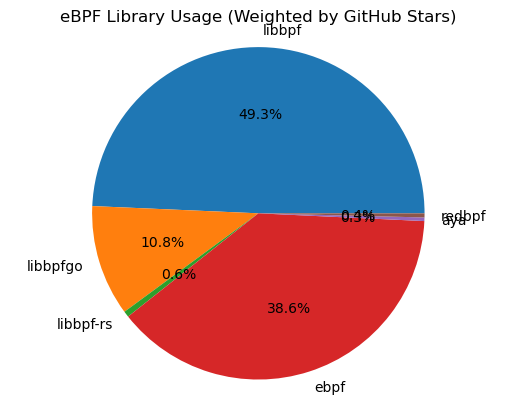

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline

libbpf_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "libbpf" }
cilium_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "ebpf" }
libbpfgo_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "libbpfgo" }
aya_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "aya" }
redbpf_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "redbpf" }
libbpf_rs_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "libbpf-rs" }

sizes = [sum(libbpf_repos.values()), sum(libbpfgo_repos.values()), sum(libbpf_rs_repos.values()), sum(cilium_repos.values()), sum(aya_repos.values()), sum(redbpf_repos.values())]
labels = 'libbpf', 'libbpfgo', 'libbpf-rs', 'ebpf', 'aya', 'redbpf'

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('eBPF Library Usage (Weighted by GitHub Stars)')
plt.axis('equal')

plt.show()

### Most popular projects using eBPF libraries

In [172]:
from collections import OrderedDict
import pandas as pd

top = OrderedDict(sorted(repos.items(), key=lambda v: v[1]['stars'], reverse=True)[0:25])
pd.DataFrame(data=top.values(), columns=["name", "library", "stars"])

,name,library,stars
0,github.com/netdata/netdata,libbpf,60451
1,github.com/go-delve/delve,ebpf,19103
2,github.com/google/gvisor,ebpf,12998
3,github.com/cilium/cilium,ebpf,12838
4,github.com/gravitational/teleport,libbpfgo,12472
5,github.com/systemd/systemd,libbpf,9984
6,github.com/opencontainers/runc,ebpf,9529
7,github.com/qemu/qemu,libbpf,6621
8,github.com/pyroscope-io/pyroscope,libbpfgo,6309
9,github.com/ehids/ecapture,ebpf,4181
